In [46]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset 

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


california_housing_dataframe = pd.read_csv("california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0


my_feature = california_housing_dataframe[["total_rooms","total_bedrooms"]]
my_feature
feature_columns = [tf.feature_column.numeric_column("total_rooms")]
targets = california_housing_dataframe["median_house_value"]

In [47]:
def my_input_fn(features, targets, batch_size=1, shuffle= True, num_epochs= None):
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size = 10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

    

In [50]:
def train_model(learning_rate, steps, batch_size, input_feature = "total_rooms"):
    periods = 10;
    steps_per_period = steps/periods
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
    my_label = "median_house_value"
    targets = california_housing_dataframe[my_label].astype('float32')
    
    # Create input functions.
    training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
    
    # Create feature columns.
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )

    # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
    print("Training model")
    print("RMSE one training data:")
    root_mean_squared_errors = []
    for period in range (0, periods):
        linear_regressor.train(
            input_fn = training_input_fn,
            steps = steps_per_period
        )
        
        predictions = linear_regressor.predict(input_fn= predict_training_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions ])
        
        root_mean_squared_error = math.sqrt(metrics.mean_squared_error(predictions,targets))
        
        print("period %02d : %0.2f" % (period, root_mean_squared_error))
        root_mean_squared_errors.append(root_mean_squared_error)
        
        y_extents = np.array([0,sample[my_label].max()])
        
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)

    # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())
    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model
RMSE one training data:
period 00 : 223.32
period 01 : 211.43
period 02 : 199.39
period 03 : 189.81
period 04 : 182.45
period 05 : 177.02
period 06 : 172.08
period 07 : 168.28
period 08 : 166.85
period 09 : 166.39
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,126.9,207.3
std,104.6,116.0
min,0.1,15.0
25%,70.2,119.4
50%,102.1,180.4
75%,151.3,265.0
max,1821.0,500.0


Final RMSE (on training data): 166.39


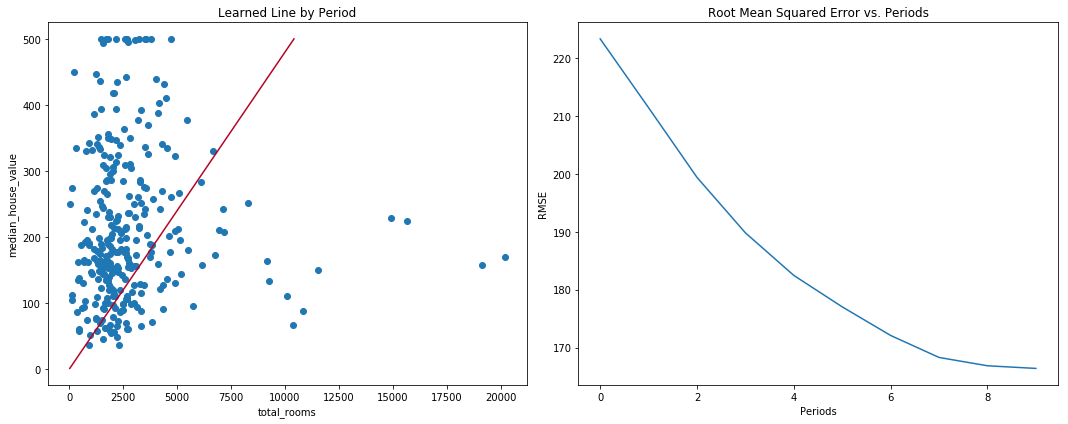

In [34]:
train_model(
    learning_rate=0.00006,
    steps=200,
    batch_size=1
)

Training model
RMSE one training data:
period 00 : 230.29
period 01 : 223.35
period 02 : 216.75
period 03 : 211.12
period 04 : 205.81
period 05 : 200.32
period 06 : 196.26
period 07 : 192.97
period 08 : 188.72
period 09 : 185.71
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,78.1,207.3
std,62.7,116.0
min,0.2,15.0
25%,43.1,119.4
50%,63.7,180.4
75%,94.0,265.0
max,1948.2,500.0


Final RMSE (on training data): 185.71


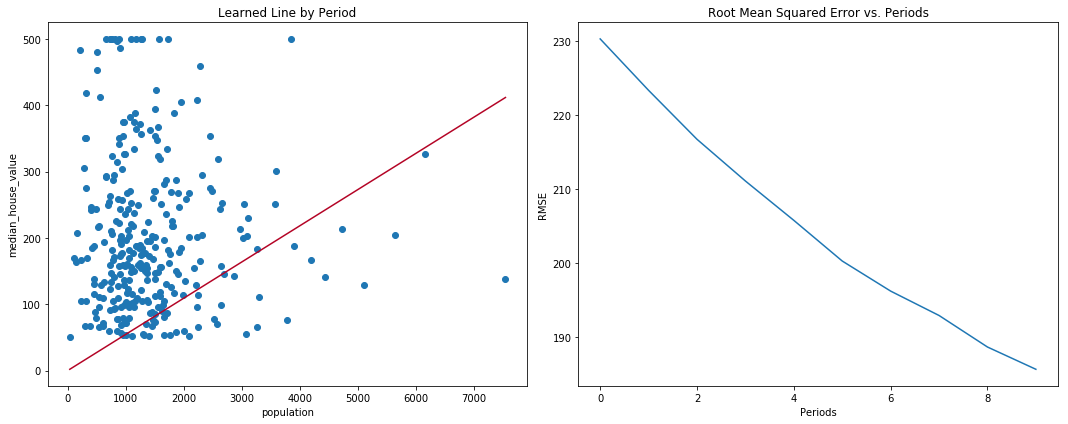

In [30]:
train_model(
    learning_rate=0.00006,
    steps=200,
    batch_size=1,
    input_feature = "population"
)

Training model
RMSE one training data:
period 00 : 222.48
period 01 : 207.97
period 02 : 194.59
period 03 : 181.51
period 04 : 170.13
period 05 : 160.16
period 06 : 151.10
period 07 : 143.75
period 08 : 137.74
period 09 : 134.50
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,152.1,207.3
std,70.5,116.0
min,33.7,15.0
25%,124.4,119.4
50%,149.7,180.4
75%,171.2,265.0
max,3362.9,500.0


Final RMSE (on training data): 134.50


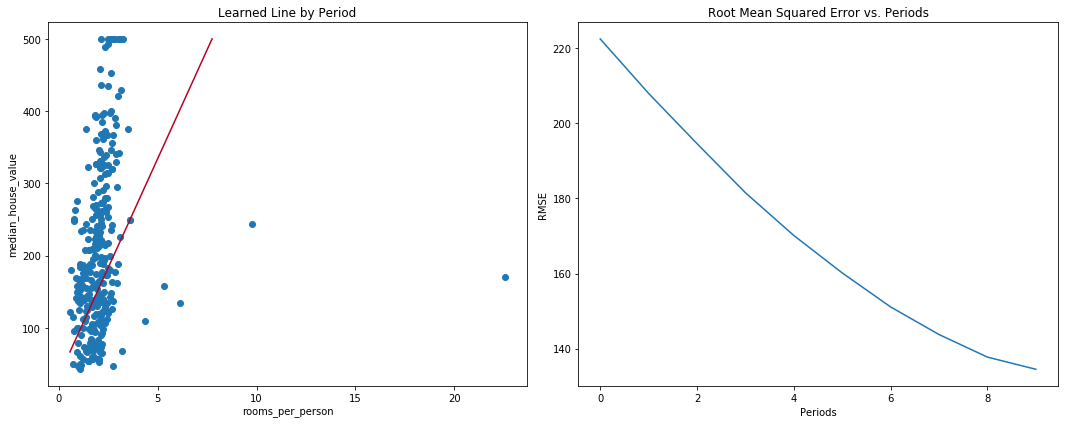

In [53]:

california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"]/california_housing_dataframe["population"])

train_model(
    learning_rate=0.03,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

Training model
RMSE one training data:
period 00 : 212.82
period 01 : 189.06
period 02 : 166.69
period 03 : 146.94
period 04 : 130.33
period 05 : 118.89
period 06 : 113.24
period 07 : 109.82
period 08 : 108.99
period 09 : 108.12
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,196.9,207.3
std,51.7,116.0
min,45.4,15.0
25%,163.9,119.4
50%,197.0,180.4
75%,225.1,265.0
max,438.0,500.0


Final RMSE (on training data): 108.12


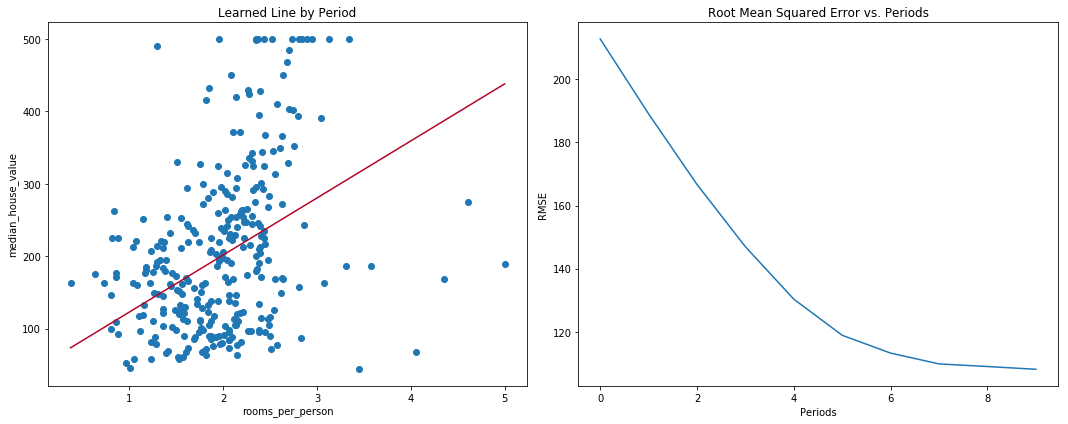

In [55]:
california_housing_dataframe["rooms_per_person"] = california_housing_dataframe["rooms_per_person"].apply(lambda x: min(x,5))
#california_housing_dataframe.describe()
#california_housing_dataframe["rooms_per_person"]
train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")